In [1]:
import copy

import torch
import torch_geometric as pyg
import numpy as np
import torch_geometric.loader

import importlib
import  src.cgvae as cgvae
importlib.reload(cgvae)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pyg.seed.seed_everything(123)

%cd /Users/cgu3/Documents/conditional-graph-variational-autoencoder
%pwd

/Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch_geometric/typing.py:85: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <149E82FB-0365-32E3-985A-BC7861332A5F> /Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <F19B5356-08DC-327C-8EE1-6C5127508CD0> /Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch_geometric/typing.py:123: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch_sparse/_version_cp

/Users/cgu3/Documents/conditional-graph-variational-autoencoder


'/Users/cgu3/Documents/conditional-graph-variational-autoencoder'

In [44]:
%qtconsole

In [ ]:
#todo: let's try another strategy, add noise to the input graph and see how well the model can recover the original graph
# todo: try to use position only in MPI network and see how well the model can recover the original graph
# validation doesn't need has regualarization term!!!
#todo: KL-loss should only be calculated at target graph

In [2]:
SPLIT_RATIO = 0.1
data = cgvae.data_transform.get_data('data/', 'Cora', mask_ratio=SPLIT_RATIO, num_val=0.1, num_test=0.2, 
                                     neg_sample_ratio=1)
# dataloader, dataset_size = get_data('data/', 'KarateClub',  mask_ratio=SPLIT_RATIO, num_val=0.5, num_test=0,  
#                                     neg_edge_ratio=5)

# Train the model

In [4]:
baseline_net = cgvae.baseline.train(
    device='cpu',
    data=data,
    num_node_features=data['input'].x.size(1),
    learning_rate=0.001,
    num_epochs=100,
    model_path='checkpoints/baseline_net.pth',
    early_stop_patience=19
)

NN Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, early_stop_count=18, loss=0.7466, phase=val]


In [11]:
cgvae_net = cgvae.cgvae_model.train(
    device='cpu',
    data=data,
    num_node_features=data['input'].x.size(1),
    learning_rate=0.005,
    num_epochs=300,
    pre_trained_baseline_net=baseline_net,
    model_path='checkpoints/cgvae_net.pth',
    early_stop_patience=50,
    regularization=1
)

CGVAE Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [4]:
# create a cgvae model from checkpoint
cgvae_net = cgvae.cgvae_model.CGVAE(
    in_channels=data['input'].x.size(1),
    hidden_size=50,
    latent_size=50,
    pre_treained_baseline_net=baseline_net
)
cgvae_net.load('checkpoints/cgvae_net.pth')

In [350]:
# current workflow will random_split link for each batch
# during test stage, need to fix this random pattern
# it can be achieve by restart kernel every time before testing
# but it is not practical so it can be fixed by recreate the dataloader and 
# make sure the test use the first batch everytime
dataloader, dataset_size = cgvae.data_transform.get_data('data/', 'Cora', mask_ratio=SPLIT_RATIO, num_val=0.1, 
                                                         num_test=0.2, 
                                     neg_edge_ratio=1)
cgvae.cgvae_model.test(cgvae_net, dataloader)

0.9577594123048668

In [44]:
# generate missing part based on the trained model

In [306]:
# sample one data from the dataloader
graphs = next(iter(dataloader))
graphs

{'input': DataBatch(x=[2708, 1433], edge_index=[2, 10428], edge_weight=[10428], batch=[2708], ptr=[2]),
 'output': DataBatch(x=[2708, 1433], edge_index=[2, 1408], edge_label=[1408], train_mask=[1408], val_mask=[1408], test_mask=[1408], batch=[2708], ptr=[2])}

In [307]:
graphs['output'].x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

# Visualize the input graph

Text(0.5, 1.0, 'Heatmap of 2D Tensor')

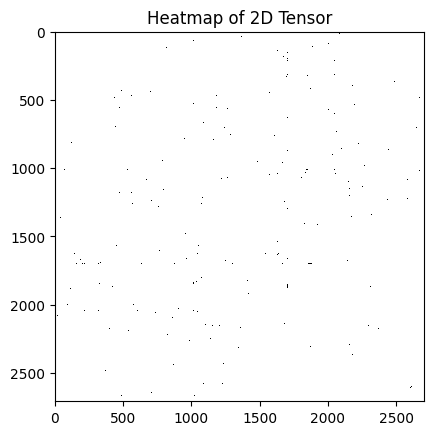

Text(0.5, 1.0, 'Heatmap of 2D Tensor')

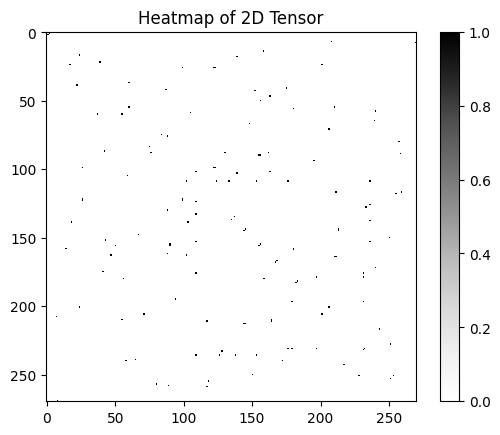

In [308]:
import matplotlib.pyplot as plt
split = int(dim * SPLIT_RATIO)
adj_mat_inp = pyg.utils.to_dense_adj(graphs['input'].edge_index, 
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
adj_mat_out = pyg.utils.to_dense_adj(graphs['output'].edge_index, 
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
# Plot the heatmap
plt.imshow(adj_mat_inp, cmap='Greys', interpolation='nearest')
plt.title("Heatmap of 2D Tensor")
plt.show()
plt.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
plt.colorbar()  # Add a colorbar to a plot
plt.title("Heatmap of 2D Tensor")
plt.show()

In [309]:
# Convert the tensor to a NumPy array
# Plot the heatmap


In [310]:
# use the trained model to generate the missing part
baseline_net(graphs['input'])

tensor([[ 0.0990, -0.0016,  0.0155,  ...,  0.0172,  0.0171,  0.0093],
        [-0.0016,  0.0151,  0.0138,  ...,  0.0096,  0.0137,  0.0155],
        [ 0.0155,  0.0138,  0.0174,  ...,  0.0167,  0.0184,  0.0194],
        ...,
        [ 0.0172,  0.0096,  0.0167,  ...,  0.0338,  0.0236,  0.0270],
        [ 0.0171,  0.0137,  0.0184,  ...,  0.0236,  0.0221,  0.0242],
        [ 0.0093,  0.0155,  0.0194,  ...,  0.0270,  0.0242,  0.0287]],
       grad_fn=<MmBackward0>)

In [311]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

<Axes: >

Text(0.5, 1.0, 'Input')

<Axes: >

<Axes: >

<Axes: >

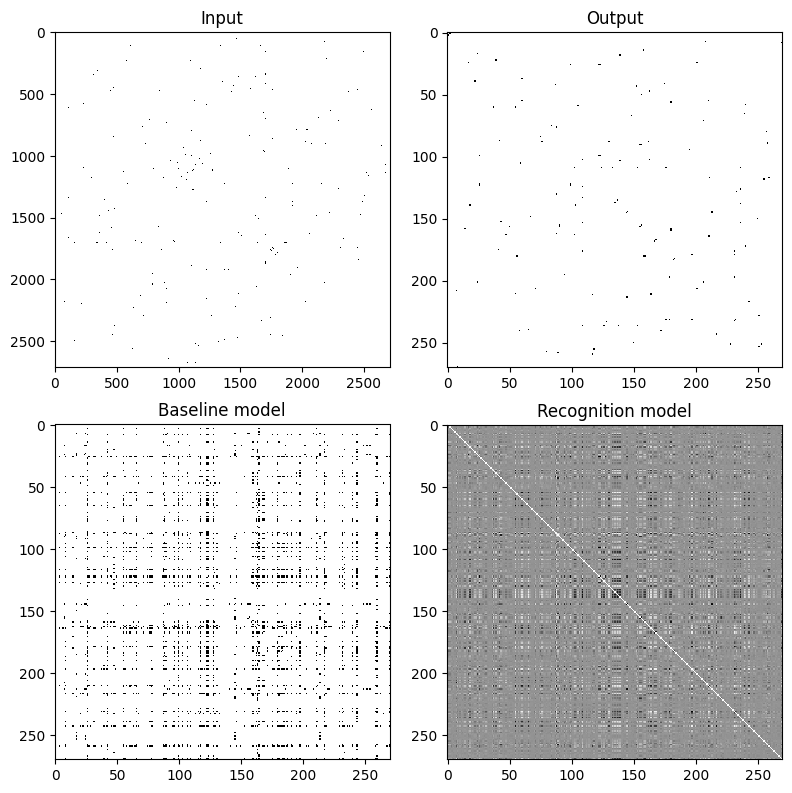

In [314]:
dim = graphs['input'].x.size(0)
adj_mat_inp = pyg.utils.to_dense_adj(graphs['input'].edge_index,
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
adj_mat_out = pyg.utils.to_dense_adj(graphs['output'].edge_index,
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
threshold = 0.8

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplot(221)
_  = plt.imshow(adj_mat_inp, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Input")

plt.subplot(222)
_ = plt.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
_ = plt.title("Output")

plt.subplot(223)
adj_mat_np = baseline_net.predict(graphs['input']).detach().numpy()[:split, :split]
# adj_mat_np[adj_mat_np < threshold] = 0
# adj_mat_np = np.random.binomial(1, adj_mat_np)
np.fill_diagonal(adj_mat_np, 0)
_ = plt.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
_ = plt.title("Baseline model")

plt.subplot(224)
adj_mat_np = np.zeros((split, split))
for i in range(100):
    adj_mat_np += sigmoid(cgvae_net.generate().detach().numpy())[:split, :split]
adj_mat_np /= 100
# adj_mat_np[adj_mat_np < threshold] = 0
# adj_mat_np[adj_mat_np >= threshold] = 1
np.fill_diagonal(adj_mat_np, 0)
_ = plt.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
_ = plt.title("Recognition model")

# also try unconditional generation


plt.show()



Text(0.5, 1.0, 'Output')

Text(0.5, 1.0, 'Recognition model generated graph (average)')

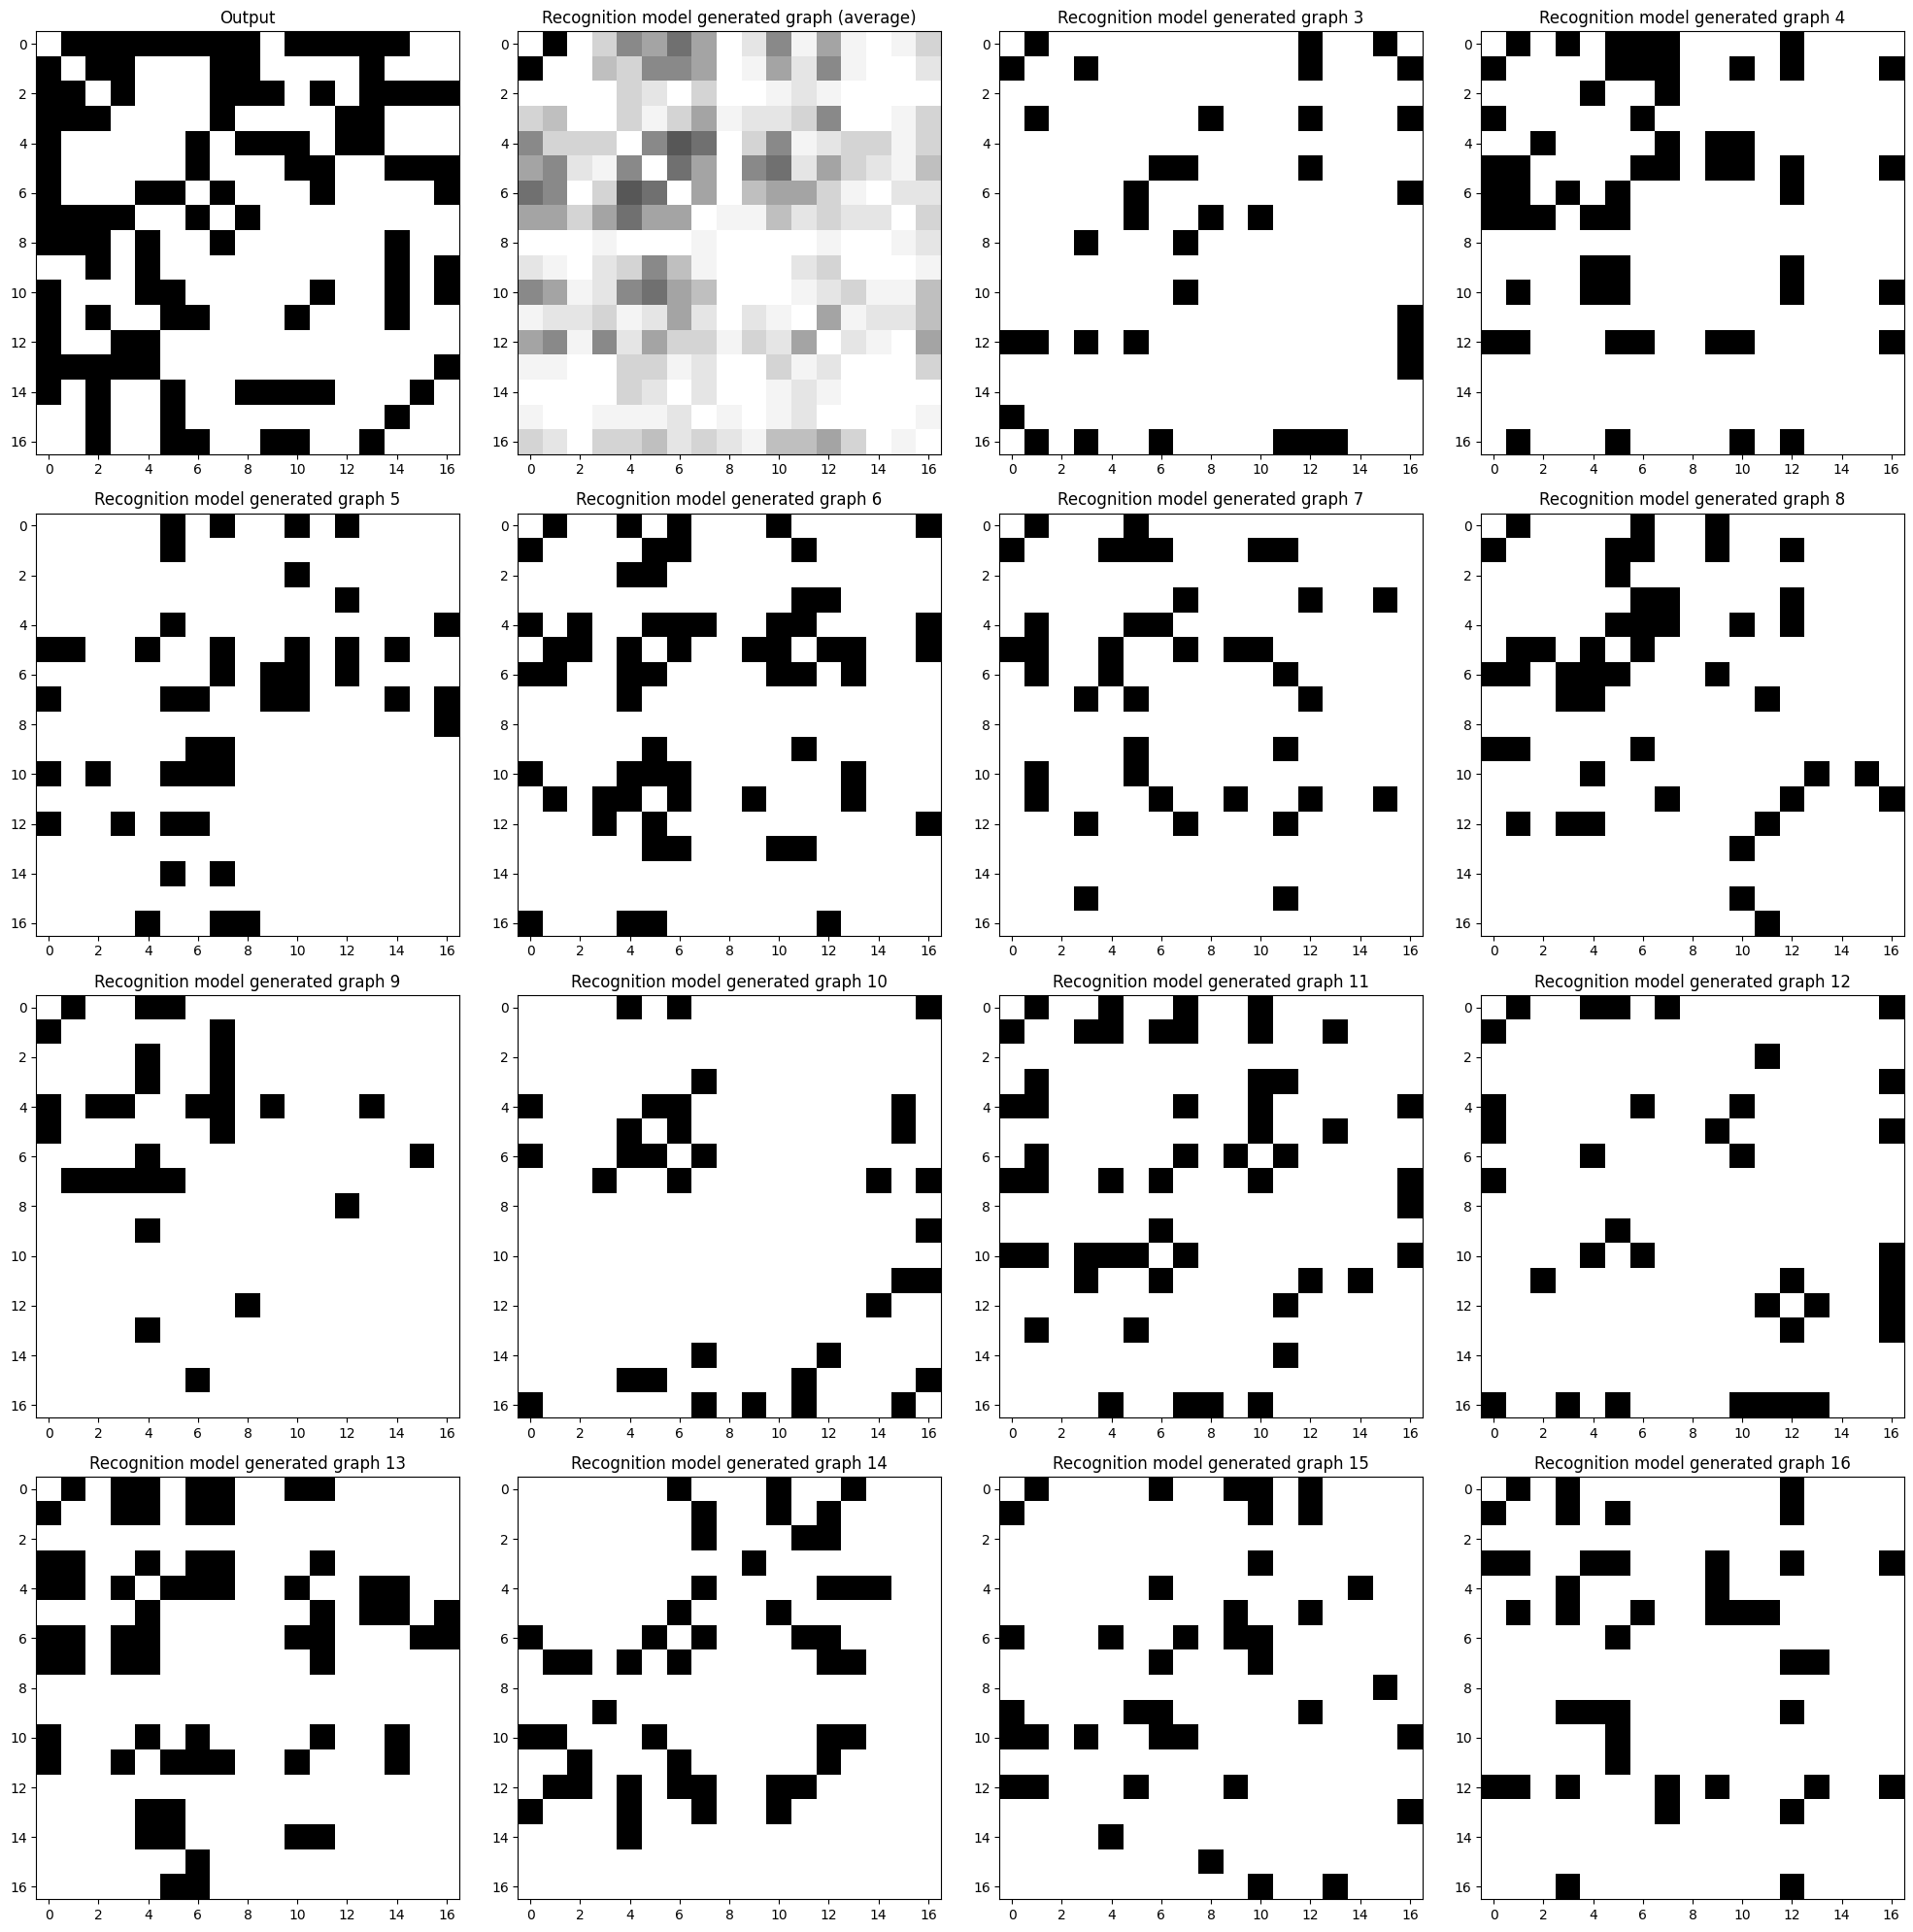

In [285]:
cgvae_net.load('checkpoints/cgvae_net.pth')
threshold = 0.7

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # Create a grid of 2 rows and 5 columns for the subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

ax = axes[0]
ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
ax.set_title("Output")

avg_adj_mat_np = np.zeros((split, split))

for i in range(2, 16):
    adj_mat_np = sigmoid(cgvae_net.generate().detach().numpy())[:split, :split]
    adj_mat_np[adj_mat_np < threshold] = 0
    adj_mat_np[adj_mat_np >= threshold] = 1
    # adj_mat_np = np.random.binomial(1, adj_mat_np)
    np.fill_diagonal(adj_mat_np, 0)
    avg_adj_mat_np += adj_mat_np
    ax = axes[i]  # Select the i-th subplot
    _ = ax.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')  # Plot the matrix in the i-th subplot
    _ = ax.set_title(f"Recognition model generated graph {i+1}")  # Set the title for the i-th subplot

avg_adj_mat_np /= 14

# avg_adj_mat_np[avg_adj_mat_np < 0.7] = 0
# avg_adj_mat_np[avg_adj_mat_np >= 0.7] = 1

ax = axes[1]
ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')
ax.set_title("Recognition model generated graph (average)")

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plots

In [294]:
import imageio
import os
import copy

# Ensure the directory exists
os.makedirs('cgvae', exist_ok=True)

threshold_values = np.linspace(0.5, 1, 10)  # Change this to the range of threshold values you want to use
filenames = []

adj_mat_np_list = []
# generate 14 graphs
for i in range(14):
    adj_mat_np_list.append(sigmoid(cgvae_net.generate().detach().numpy())[:split, :split])

for t in threshold_values:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
    axes = axes.flatten()

    ax = axes[0]
    _ = ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
    _ = ax.set_title("Output")

    avg_adj_mat_np = np.zeros((split, split))
    adj_mat_np_list_temp =copy.deepcopy(adj_mat_np_list)
    for adj_mat_np in adj_mat_np_list_temp:
        adj_mat_np[adj_mat_np < t] = 0
        adj_mat_np[adj_mat_np >= t] = 1
        np.fill_diagonal(adj_mat_np, 0)
        avg_adj_mat_np += adj_mat_np
    
    # avg_adj_mat_np[avg_adj_mat_np < threshold] = 0
    # avg_adj_mat_np[avg_adj_mat_np >= threshold] = 1
    # plot the average
    avg_adj_mat_np /= 14
    ax = axes[1]
    _ = ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')

    # plot the rest
    for i in range(2, 16):
        ax = axes[i]
        _ = ax.imshow(adj_mat_np_list_temp[i-2], cmap='Greys', interpolation='nearest')
        _ = ax.set_title(f"Recognition model generated graph {i}")

    avg_adj_mat_np /= 14
    ax = axes[1]
    _ = ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')
    _= ax.set_title("Recognition model generated graph (average)")

    plt.tight_layout()

    # Save the figure to a file
    filename = f'cgvae/output_{t}.png'
    plt.savefig(filename)
    filenames.append(filename)

    plt.close()  # Close the figure to free up memory

In [295]:
# from the images make a video
images = [imageio.imread(filename) for filename in filenames]
imageio.mimsave('cgvae/output2.gif', images, fps=1)

# remove the files
# for filename in filenames:
#     os.remove(filename)

/var/folders/xs/_jggb8_n03q3bxbybznls2w1q5_5xx/T/ipykernel_71254/3300650343.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]


# Vanilla Variational Graph Autoencoder

In [288]:
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import ToUndirected
from torch_geometric.datasets import Planetoid, KarateClub
import torch_geometric.transforms as T
from datetime import time
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch_geometric.nn import VGAE
# Unconditional generation
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2* out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class VGAEWithGenerate(VGAE):
    def __init__(self, encoder):
        super().__init__(encoder)
        self.encoder = encoder
        
    def generate(self):
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return self.decoder.forward_all(z)
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))




In [352]:
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid

random_link_split = RandomLinkSplit(is_undirected=True,
                                         num_val=0.1, num_test=0.2,
                                         neg_sampling_ratio=1,
                                         split_labels=True)
dataset = Planetoid(root='data/cora2', name='Cora',
                    transform= T.Compose([
                        T.ToUndirected(),
                        T.NormalizeFeatures(), random_link_split]))
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
next(iter(dataloader))

Processing...
Done!


[DataBatch(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[3696], pos_edge_label_index=[2, 3696], neg_edge_label=[3696], neg_edge_label_index=[2, 3696], batch=[2708], ptr=[2]),
 DataBatch(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[527], pos_edge_label_index=[2, 527], neg_edge_label=[527], neg_edge_label_index=[2, 527], batch=[2708], ptr=[2]),
 DataBatch(x=[2708, 1433], edge_index=[2, 8446], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[1055], pos_edge_label_index=[2, 1055], neg_edge_label=[1055], neg_edge_label_index=[2, 1055], batch=[2708], ptr=[2])]

In [384]:
vgae_model = VGAEWithGenerate(VariationalGCNEncoder(dataset.num_node_features, out_channels=16))
model = vgae_model.to(device)

In [308]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(1, 200 + 1):
    bar = tqdm(dataloader,
               desc='CVAE Epoch {}'.format(epoch).ljust(20))
    for train, val, test in bar:
        batch = train.to(device)
        optimizer.zero_grad()
        z = model.encode(batch.x, batch.pos_edge_label_index)
        loss = model.recon_loss(z, batch.pos_edge_label_index, batch.neg_edge_label_index)
        loss = loss + (1 / batch.size(0)) * model.kl_loss()
        loss.backward()
        optimizer.step()
        bar.set_postfix({'loss': loss.item()})

VGAEWithGenerate(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(1433, 32)
    (conv_mu): GCNConv(32, 16)
    (conv_logstd): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)

CVAE Epoch 200      : 100%|██████████| 1/1 [00:00<00:00, 46.57it/s, loss=0.889]


In [354]:
import torch.optim as optim
pyg.seed.seed_everything(123) # random_link_split data leakage

# vgae_model = VGAEWithGenerate(VariationalGCNEncoder(dataset.num_node_features, out_channels=16))
# model = vgae_model.to(device)

train_data, val_data, test_data = dataset[0]
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    if True:
        loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

times = []
for epoch in range(1, 400 + 1):
    loss = train()
    auc, ap = test(test_data)
    print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")


Epoch: 001, AUC: 0.6915, AP: 0.7275
Epoch: 002, AUC: 0.6917, AP: 0.7273
Epoch: 003, AUC: 0.6920, AP: 0.7275
Epoch: 004, AUC: 0.6912, AP: 0.7267
Epoch: 005, AUC: 0.6904, AP: 0.7262
Epoch: 006, AUC: 0.6898, AP: 0.7256
Epoch: 007, AUC: 0.6894, AP: 0.7251
Epoch: 008, AUC: 0.6889, AP: 0.7245
Epoch: 009, AUC: 0.6885, AP: 0.7240
Epoch: 010, AUC: 0.6882, AP: 0.7235
Epoch: 011, AUC: 0.6879, AP: 0.7231
Epoch: 012, AUC: 0.6875, AP: 0.7227
Epoch: 013, AUC: 0.6874, AP: 0.7226
Epoch: 014, AUC: 0.6871, AP: 0.7225
Epoch: 015, AUC: 0.6871, AP: 0.7226
Epoch: 016, AUC: 0.6871, AP: 0.7227
Epoch: 017, AUC: 0.6871, AP: 0.7227
Epoch: 018, AUC: 0.6869, AP: 0.7226
Epoch: 019, AUC: 0.6867, AP: 0.7224
Epoch: 020, AUC: 0.6866, AP: 0.7221
Epoch: 021, AUC: 0.6864, AP: 0.7218
Epoch: 022, AUC: 0.6862, AP: 0.7216
Epoch: 023, AUC: 0.6863, AP: 0.7215
Epoch: 024, AUC: 0.6862, AP: 0.7214
Epoch: 025, AUC: 0.6860, AP: 0.7212
Epoch: 026, AUC: 0.6859, AP: 0.7209
Epoch: 027, AUC: 0.6856, AP: 0.7205
Epoch: 028, AUC: 0.6853, AP:

In [394]:
from pathlib import Path
from tqdm import tqdm
import torch.optim as optim

def train_model(model, epoch, learning_rate, early_stop_patience, model_path, device='cpu'):
    model.to(device)
    
    early_stop_count = 0
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_loss = np.Inf
    
    for epoch in range(epoch):
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            bar = tqdm(dataloader, desc='VGAE Epoch {}'.format(epoch).ljust(20))
            for train, val, test in bar:
                if phase == 'train':
                    batch = train.to(device)
                else:
                    batch = val.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    # why zero_grad need to be after set_grad_enabled
                    z = model.encode(batch.x, batch.pos_edge_label_index)
                    loss = model.recon_loss(z, batch.pos_edge_label_index, batch.neg_edge_label_index)
                    loss = loss + (1 / batch.size(0)) * model.kl_loss()
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                bar.set_postfix(phase=phase, loss='{:.4f}'.format(loss),
                                  early_stop_count=early_stop_count)
            
                if phase == 'val':
                    # save the best loss
                    if loss.item() < best_loss:
                        best_loss = loss.item()
                        torch.save(model.state_dict(), model_path)
                        early_stop_count = 0
                    else:
                        early_stop_count += 1
        
        if early_stop_count >= early_stop_patience:
            break
                    
    model.load(model_path)
    model.eval()
        
    # save the final model
    Path(model_path).parent.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), model_path)

In [395]:
train_model(model, 300, 0.01, 300, 'checkpoints/vgae_net.pth')

VGAE Epoch 299      : 100%|██████████| 1/1 [00:00<00:00, 70.48it/s, early_stop_count=0, loss=0.9009, phase=val]


In [396]:
from sklearn.metrics import roc_auc_score, average_precision_score
pyg.seed.seed_everything(123)

def test_model(model, dataloader):
    model.eval()
    with torch.no_grad():
        for train, val, test in dataloader:
            batch = test.to(device)
            logits = model.generate()
            pos_pred_logits = logits[batch.pos_edge_label_index[0], batch.pos_edge_label_index[1]].cpu().numpy()
            neg_pred_logits = logits[batch.neg_edge_label_index[0], batch.neg_edge_label_index[1]].cpu().numpy()
            pred_logits = np.concatenate((pos_pred_logits, neg_pred_logits))
            # create a torch tensor with 0 and 1 for edge and non-edge with
            # length the same as pos_edge_label and neg_edge_label
            true_labels = torch.cat([torch.ones(batch.pos_edge_label.size(0)),
                                     torch.zeros(batch.neg_edge_label.size(0))])
            # calculate AUC for each batch for output_logits and output_labels
            roc_auc = roc_auc_score(true_labels, pred_logits)
            # calculate average precision
            average_precision = average_precision_score(true_labels, pred_logits)

    # print the average AUC and average precision
    print(f"AUC: {roc_auc}, AP: {average_precision}")

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
test_model(model, dataloader)

AUC: 0.8919988320118596, AP: 0.8876463104321649


In [49]:

threshold = 0.5

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # Create a grid of 2 rows and 5 columns for the subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

ax = axes[0]
ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
ax.set_title("Output")

avg_adj_mat_np = np.zeros((split, split))
for i in range(2, 16):
    adj_mat_np = vgae_model.generate().detach().numpy()[:split, :split]
    adj_mat_np[adj_mat_np < threshold] = 0
    adj_mat_np[adj_mat_np >= threshold] = 1
    # adj_mat_np = np.random.binomial(1, adj_mat_np)
    np.fill_diagonal(adj_mat_np, 0)
    avg_adj_mat_np += adj_mat_np
    ax = axes[i]  # Select the i-th subplot
    _ = ax.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')  # Plot the matrix in the i-th subplot
    _ = ax.set_title(f"Unconditional VAE generated graph {i+1}")  # Set the title for the i-th subplot

avg_adj_mat_np /= 14
# avg_adj_mat_np[avg_adj_mat_np < 0.7] = 0
# avg_adj_mat_np[avg_adj_mat_np >= 0.7] = 1

ax = axes[1]
ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')
ax.set_title("Recognition model generated graph (average)")


plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plots

NameError: name 'plt' is not defined

In [296]:
import imageio
import os
import copy

# Ensure the directory exists
os.makedirs('vgae', exist_ok=True)

threshold_values = np.linspace(0.5, 1, 10)  # Change this to the range of threshold values you want to use
filenames = []

adj_mat_np_list = []
# generate 14 graphs
for i in range(14):
    adj_mat_np_list.append(sigmoid(vgae_model.generate().detach().numpy())[:split, :split])

for t in threshold_values:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
    axes = axes.flatten()

    ax = axes[0]
    _ = ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
    _ = ax.set_title("Output")

    avg_adj_mat_np = np.zeros((split, split))
    adj_mat_np_list_temp =copy.deepcopy(adj_mat_np_list)
    for adj_mat_np in adj_mat_np_list_temp:
        adj_mat_np[adj_mat_np < t] = 0
        adj_mat_np[adj_mat_np >= t] = 1
        np.fill_diagonal(adj_mat_np, 0)
        avg_adj_mat_np += adj_mat_np

    # avg_adj_mat_np[avg_adj_mat_np < threshold] = 0
    # avg_adj_mat_np[avg_adj_mat_np >= threshold] = 1
    # plot the average
    avg_adj_mat_np /= 14
    ax = axes[1]
    _ = ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')

    # plot the rest
    for i in range(2, 16):
        ax = axes[i]
        _ = ax.imshow(adj_mat_np_list_temp[i-2], cmap='Greys', interpolation='nearest')
        _ = ax.set_title(f"Recognition model generated graph {i}")

    avg_adj_mat_np /= 14
    ax = axes[1]
    _ = ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')
    _= ax.set_title("Recognition model generated graph (average)")

    plt.tight_layout()

    # Save the figure to a file
    filename = f'vgae/output_{t}.png'
    plt.savefig(filename)
    filenames.append(filename)

    plt.close()  # Close the figure to free up memory

In [297]:
# from the images make a video
images = [imageio.imread(filename) for filename in filenames]
imageio.mimsave('vgae/output.gif', images, fps=1)

/var/folders/xs/_jggb8_n03q3bxbybznls2w1q5_5xx/T/ipykernel_71254/3859299581.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]


# Experiment 

Let's random remove some edges from the input graph and see how well the models can recover the missing edges.

In [ ]:
graphs